# Script de reconhecimento facial

O código a seguir permite processar um vídeo curto e fazer a detecção de faces e o reconhecimento dos rostos a partir das imagens de treinamento. Além disso, é possível calcular o tempo em que cada pessoa aparece na tela, bem como realizamos na reportagem [BBB 23: Inteligência artificial revela quem mais apareceu nos VTs do programa](https://www.estadao.com.br/emais/tv/bbb-23-inteligencia-artificial-revela-quem-mais-apareceu-nos-vts-do-programa/).

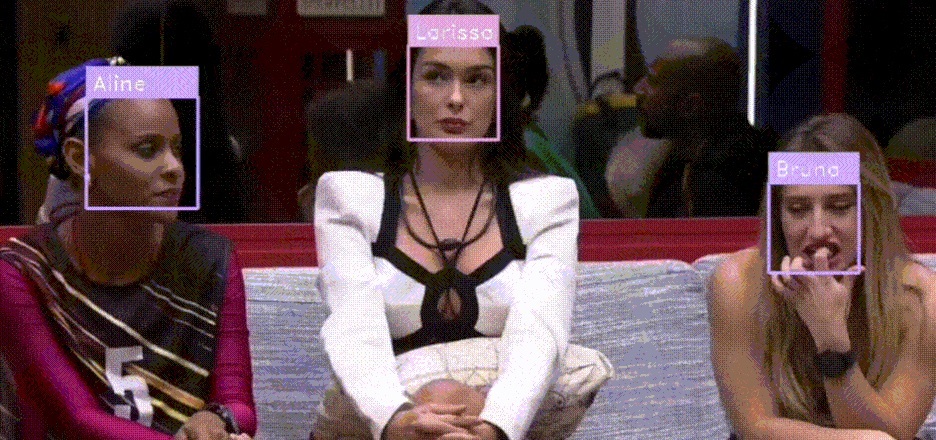
**Para iniciar, faça primeiro as seguintes etapas:**

1. Criar uma cópia deste notebook indo em `Arquivo` --> `Salvar uma cópia no Drive`;
2. Depois vá no menu em `Ambiente de execução` --> `Alterar tipo de ambiente de execução` --> e em `Acelerados de hardware` selecione `GPU`;
3. Baixar os arquivos do repositório no GitHub [neste link](https://github.com/lucasthaynan/workshop-reconhecimento-facial). Para baixar vá em `Code` (botão verde) e depois em `Download ZIP`;
4. Em seguida, instale as bibliotecas abaixo.


In [ ]:
!pip install flask --quiet
!pip install flask-ngrok --quiet
!pip install face_recognition --quiet

### Criando pasta no Drive para subir os arquivos
Vamos criar uma pasta para subir todos os arquivos de treino, o vídeo a ser processado e o index.html baixados do repositório do GitHub.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

name_file = 'arquivos_reconhecimento_facial'

directory = f'/content/drive/My Drive/{name_file}'
if not os.path.exists(directory):
    os.makedirs(directory)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importando bibliotecas necessárias

In [ ]:
from flask import Flask, render_template, Response  # bibliotecas Flask para criar a aplicação web, render_template para renderizar os templates HTML e Response para enviar respostas HTTP.
from flask_ngrok import run_with_ngrok  # biblioteca flask_ngrok para permitir que a aplicação Flask seja executada em um servidor ngrok.
import cv2  # biblioteca OpenCV (cv2) para manipulação e processamento de imagens e vídeos.
import face_recognition  # biblioteca para reconhecimento facial.
import numpy as np  # biblioteca NumPy para realizar operações matemáticas em arrays multidimensionais.
import pandas as pd # biblioteca para trabalhar com dados em diversos formatos, como CSV.


### Criando subdomínio de hospdegem em um servidor temporário do ngrok.com

In [ ]:
# Instale a versão do ngrok para Linux usando o seguinte comando ou você pode obter a versão mais recente em seu site oficial - https://dashboard.ngrok.com/get-started/setup
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz

# Extraia o arquivo baixado usando o seguinte comando
!tar -xvf /content/ngrok-stable-linux-amd64.tgz

# Cola seu AuthToken aqui e execute este comando
!./ngrok authtoken 23H0IY10fqeKMIW7kG05JhKZMae_3Zabr2iqkU9AUcZ7CrRTP


--2023-06-21 17:02:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 18.205.222.128, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13856790 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz.1’

ngrok-stable-linux- 100%[===================>]  13.21M  40.1MB/s    in 0.3s    

2023-06-21 17:02:29 (40.1 MB/s) - ‘ngrok-stable-linux-amd64.tgz.1’ saved [13856790/13856790]

ngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


### Testando se o nosso site está funcionando no servidor temporários

In [ ]:

app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def hello():
    return "Nosso site de teste está no ar \o/"

if __name__ == "__main__":
    app.run()


### Script de reconhecimento facial usando as bibliotecas `opencv` e `face_recognition`

In [ ]:

# carregando vídeo a ser processado
video_capture = cv2.VideoCapture(f"{directory}/video/debate_2022.mp4")

# carregando imagem do Lula de treino
lula_image = face_recognition.load_image_file(f"{directory}/fotos_treino/lula.png")
lula_face_encoding = face_recognition.face_encodings(lula_image)[0]

# carregando imagem do Bolsonaro de treino
bolsonaro_image = face_recognition.load_image_file(f"{directory}/fotos_treino/bolsonaro.jpg")
bolsonaro_face_encoding = face_recognition.face_encodings(bolsonaro_image)[0]

# salvando encondings das imagens em uma lista
known_face_encodings = [
    lula_face_encoding,
    bolsonaro_face_encoding
]

known_face_names = [
    "Lula",
    "Bolsonaro"
]

face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

df_dados = pd.DataFrame()

# funcao para detectar as faces presentes no vídeos
def detecta_faces(frame):
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    rgb_small_frame = small_frame[:, :, ::-1]
    rgb_small_frame = cv2.cvtColor(rgb_small_frame, cv2.COLOR_BGR2RGB)

    face_locations = face_recognition.face_locations(rgb_small_frame, model="CNN", number_of_times_to_upsample=1)
    face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

    face_names = []
    for face_encoding in face_encodings:
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance=0.55)
        name = "Desconhecido"

        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = known_face_names[best_match_index]

        face_names.append(name)

    return face_locations, face_names


time_video = 0
time_lula = 0
time_bolsonaro = 0

def processa_frames():

    # definindo variáveis de tempo como global
    global time_video
    global time_lula
    global time_bolsonaro

    while True:
        # tempo para cada frame do vídeo (0.0333 segundos)
        # site para ver o total de frames/s: https://www.flexclip.com/index.php?option=com_tools&lang=pt&view=metadata/
        time_video += 0.0333

        # Lê o próximo quadro do vídeo
        success, frame = video_capture.read()

        if not success:
            break

        # Detecta as faces no quadro e obtém as localizações e nomes
        face_locations, face_names = detecta_faces(frame)

        for (top, right, bottom, left), name in zip(face_locations, face_names):
            top *= 4  # Redimensiona as coordenadas das faces para o tamanho original
            right *= 4
            bottom *= 4
            left *= 4

            # Desenha retângulos nas faces detectadas com base no nome
            if name == "Desconhecido":
                cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)  # Desenha retângulo vermelho na face desconhecida
                cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)  # Desenha retângulo vermelho para o texto
                font = cv2.FONT_HERSHEY_DUPLEX
                cv2.putText(frame, name, (left + 6, bottom - 6), font, 0.85, (255, 255, 255), 1)  # Escreve o nome "Desconhecido" em branco

            else:
                if name.startswith('Lula'):
                    time_lula += 0.0333

                if name.startswith('Bolsonaro'):
                    time_bolsonaro += 0.0333

                cv2.rectangle(frame, (left, top), (right, bottom), (255, 165, 0), 2)  # Desenha retângulo azul na face conhecida
                cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (255, 165, 0), cv2.FILLED)  # Desenha retângulo azul para o texto
                font = cv2.FONT_HERSHEY_DUPLEX
                cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)  # Escreve o nome da face conhecida em branco

        # Codifica o quadro em formato JPEG
        ret, buffer = cv2.imencode('.jpg', frame)
        frame = buffer.tobytes()

        # Retorna o quadro como um objeto de transmissão
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')



### Executando o reconhecimento facial dentro da interface do Flask

In [ ]:
# carregando vídeo a ser processadoimport os
app = Flask(__name__, template_folder = f"{directory}/templates")
run_with_ngrok(app)

@app.route('/video_feed')
def video_feed():
    return Response(processa_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/')
def index():
    return render_template("index.html")

if __name__ == '__main__':
    app.run()


### Criando dataframe com os dados gerados

In [ ]:


dados = {
    'tempo_video': round(time_video, 3),
    'tempo_pessoa': {
        'Lula': round(time_lula, 3),
        'Bolsonaro': round(time_bolsonaro, 3),
    },
    'percentual_pessoa': {
        'Lula': round((time_lula/time_video)*100, 2),
        'Bolsonaro': round((time_bolsonaro/time_video)*100, 2),

    }
}

df = pd.DataFrame(dados)

display(df)